In [70]:
%pip install pandas
%pip install numpy
%pip install matplotlib
%pip install scikit-learn

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.comNote: you may need to restart the kernel to use updated packages.




[notice] A new release of pip available: 22.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator)

df = pd.read_csv("Crime_Data_from_2020_to_Present.csv", converters={'TIME OCC': str}, index_col=False)

df["DATE OCC"] = pd.to_datetime(df["DATE OCC"].str.split(" ").str[0] + df["TIME OCC"], format='%m/%d/%Y%H%M')
df["Date Rptd"] = pd.to_datetime(df["Date Rptd"].str.split(" ").str[0], format='%m/%d/%Y')
df.drop(['DR_NO', 'TIME OCC', 'Part 1-2', 'Crm Cd 1', 'Crm Cd 2', 'Crm Cd 3', 'Crm Cd 4', 'Status', 'Status Desc', 'Cross Street', 'Premis Cd', 'Premis Desc', 'Weapon Used Cd', 'Weapon Desc', 'Mocodes'], axis=1, inplace=True)

df = df.sort_values(by=["DATE OCC"]).reset_index(drop=True)

import datetime as dt

years = [2020, 2022, 2023]

crime_years = [df[df["DATE OCC"].dt.year == y] for y in years]
print(len(crime_years))

temp = pd.concat([crime_years[0], crime_years[1]])
crime_final = pd.concat([temp, crime_years[2]])

3


In [72]:
crime_final = crime_final[(crime_final["LON"] != 0) & (crime_final["LAT"] != 0)]

In [73]:
# Obliczanie estymatora wariancji j-tej współrzędnej: x -> wartości losowe, m -> liczba wartości


def calculate_Vj(x, m):
  sum_1 = 0.0
  sum_2 = 0.0

  for i in range(m):
    sum_1 += x[i]**2
    sum_2 += x[i]

  return   (1. / (m - 1)) * sum_1 - (1. / (m*(m - 1))) * sum_2**2

# Czwarta pochodna funkcji K
def K_4(x):
  return (1. / np.sqrt(2*np.pi)) * (np.power(x, 4) - 6*np.power(x, 2) + 3) * np.exp(-x ** 2 / 2.)

# Szósta pochodna funkcji K
def K_6(x):
  return (1. / np.sqrt(2*np.pi)) * (np.power(x , 6.) - 15*np.power(x, 4) + 45*np.power(x, 2) - 15) * np.exp(-x ** 2 / 2.)


# Obliczanie współczynnika C: x -> wartości losowe, m -> liczba wartości, h -> współczynnik h (inny niż ten co mamy ostatecznie policzyć),
#                             xi -> współczynnik xi (ten taki grecki zawijas), K_n -> n-ta pochodna funkcji K

def calculate_C(x, m, h, xi, K_n):

  sum = 0.
  for i in range(m):
    for j in range(m):
      sum += K_n(((x[i] - x[j]) / h))

  return (1. / (m**2 * np.power(h, xi + 1.))) * sum

# Obliczanie parametru wygładzania h: x -> zbiór wartości, m -> liczba wartości, h -> współczynnik h (inny niż ten co mamy ostatecznie policzyć),
#                                     xi -> współczynnik xi (ten taki grecki zawijas), K -> funkcja K, x0 -> przesunięcie funkcji K o stałe

def calculate_h(x, m):

  #1. Obliczamy estymator wariancji
  V = calculate_Vj(x, m)

  #2. Obliczamy estymator odchylenia standardowego
  sigma = np.sqrt(V)

  #3. Obliczamy wartośc c8
  c8 = 105. / (32. * np.sqrt(np.pi) * np.power(sigma, 9))

  #4. Obliczamy wartość hII
  #K6_0 -> szósta pochodna K w x = 0
  K6_0 = K_6(0.)

  Uk = 1.
  hII = np.power(((-2 * K6_0) / (Uk * c8 * m)), 1 / 9.)

  #5. Obliczamy wartość C6_h11
  C6_hII = calculate_C(x, m, hII, 6., K_6)

  #6. Obliczamy wartość hI, K4_0 -> wartość czwartej pochodnej K w punkcie 0
  K4_0 = K_4(0.)

  hI = np.power(((-2. * K4_0) / (Uk * C6_hII * m)), 1. / 7)

  #7. Obliczamy wartość C4_hI
  C4_hI = calculate_C(x, m, hI, 4., K_4)


  #8. Obliczamy h0, wiedząc że Z(f) = C4_hI
  Wk = 1. / (2 * np.sqrt(np.pi))
  h0 = np.power((Wk / (Uk ** 2 * C4_hI * m)), 1 / 5.)

  return h0

In [74]:
def plot_histogram(random_nums, lower_bound, upper_bound, num_bins = 10, size = 1000, move = 0.5, hist = False):

  fig, axes = plt.subplots(figsize=(12, 5))
  if not hist:
    hist_10, be_10 = np.histogram(random_nums, bins=num_bins, density=True)
    axes.scatter(be_10[1:] - move, hist_10, color='red', marker='_', s=size, linewidth=2.5)
  else:
    axes.hist(random_nums, bins=num_bins, density=True, range=(lower_bound, upper_bound), color='red', histtype='step')
  axes.set_title(f'Histogram dla {len(random_nums)} wartości')
  axes.set_xticks(np.arange(0, upper_bound, 1.0))
  axes.set_yticks(np.arange(0,0.6, 0.1))
  axes.set_xlabel('x')
  axes.set_ylabel('y')
  axes.grid(True)

#### Bierzemy 1000 rekordów z jednej z kategorii przestępstw, zw. na długie czasy obliczeń.

In [75]:
crimes_categories_names = ["Abuse", "Theft", "Fraud", "Property Damage / Theft", "Threats", "Sexual Crimes", "Other Crimes"]
crimes_categories_codes = [[110, 113, 230, 231, 235, 236, 237, 250, 251, 434, 435, 436, 622, 623, 624, 625, 626, 627, 870, 910, 920, 921, 922, 943],
                           [210, 220, 310, 320, 330, 331, 341, 343, 347, 349, 350, 351, 352, 353, 354, 410, 420, 421, 433, 440, 441, 442, 443, 444, 446, 450, 451, 452, 470, 471, 473, 474, 475],
                           [649, 651, 652, 653, 654, 660, 662, 664, 666, 668, 670, 942, 950, 951],
                           [647, 648, 740, 745, 888, 433, 438, 480, 485, 487, 510, 520, 522],
                           [940, 753, 755, 756, 763, 928, 933, 930],
                           [760, 762, 805, 806, 810, 812, 813, 814, 815, 820, 821, 822, 845, 850, 932, 956, 121, 122, 860],
                           [437, 439, 661, 761, 880, 886, 890, 900, 901, 902, 903, 906, 931, 944, 946, 949, 954, 865]]

In [76]:
def split_crime_by_code(df):
    split_crimes = {}

    for i in range(len(crimes_categories_names)):
        split_crimes[crimes_categories_names[i]] = df[df['Crm Cd'].isin(crimes_categories_codes[i])].reset_index()
    
    return split_crimes

def split_crimes_by_year(split: dict):
    years = [2020, 2022, 2023]
    
    res = []

    for year in years:
        temp = {}
        for label in split.keys():
            temp[label] = split[label][split[label]['DATE OCC'].dt.year == year]
        res.append(temp)
    
    return res


split = split_crime_by_code(crime_final)
split_years = split_crimes_by_year(split)

In [77]:
display(split_years[0]['Abuse'])

,index,Date Rptd,DATE OCC,AREA,AREA NAME,Rpt Dist No,Crm Cd,Crm Cd Desc,Vict Age,Vict Sex,Vict Descent,LOCATION,LAT,LON
0,17,2020-08-10,2020-01-01 00:01:00,4,Hollenbeck,429,626,INTIMATE PARTNER - SIMPLE ASSAULT,28,F,H,3700 LOWELL AV,34.0882,-118.1624
1,18,2022-04-16,2020-01-01 00:01:00,20,Olympic,2054,230,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",45,F,O,900 S NORMANDIE AV,34.0533,-118.3003
2,40,2023-03-15,2020-01-01 00:01:00,13,Newton,1364,626,INTIMATE PARTNER - SIMPLE ASSAULT,42,F,H,4600 HOOPER AV,33.9994,-118.2543
3,57,2020-09-02,2020-01-01 00:01:00,12,77th Street,1265,627,CHILD ABUSE (PHYSICAL) - SIMPLE ASSAULT,6,M,H,8200 S VERMONT AV,33.9655,-118.2918
4,61,2020-08-21,2020-01-01 00:01:00,17,Devonshire,1764,626,INTIMATE PARTNER - SIMPLE ASSAULT,33,F,H,9600 CORBIN AV,34.2446,-118.5623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46087,199777,2021-01-01,2020-12-31 23:40:00,15,N Hollywood,1555,625,OTHER ASSAULT,43,M,O,11100 OTSEGO ST,34.1630,-118.3709
46088,199781,2021-01-04,2020-12-31 23:50:00,15,N Hollywood,1532,624,BATTERY - SIMPLE ASSAULT,25,M,H,12300 OXNARD ST,34.1794,-118.4009
46089,199782,2020-12-31,2020-12-31 23:50:00,18,Southeast,1829,626,INTIMATE PARTNER - SIMPLE ASSAULT,24,F,H,97TH ST,33.9483,-118.2290
46090,199783,2020-12-31,2020-12-31 23:55:00,5,Harbor,504,230,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",24,M,H,TORRANCE,33.8416,-118.3040


In [119]:
def k(x, x0 = 0., h = 1.):
    return 1/np.sqrt(2*np.pi) * np.exp(-((x-x0)/h)**2/2)

def gauss_calc(x, x0, m, K = k, h=1.0):
  result = K(x, x0[0])
  for i in range(1, m):
    result += K(x, x0[i], h)
  result = result/(float(m)*h)
  return result

def convert_date_to_numbers(tab):
  min_date = np.min(tab)

  for i in range(len(tab)):
    tab[i] = float((tab[i] - min_date).days)

  return tab

def gauss_calc_df(split, category, m, K = k, h = 1.):
  temp = split[category].copy()
  temp = temp.sample(n=m, random_state=12)

  extract_columns = ['DATE OCC', 'LAT', 'LON']
  temp['DATE OCC'] = temp['DATE OCC'].dt.date



  gauss_res = []
  for extract in extract_columns:
    column = temp[extract].to_numpy()

    if extract == 'DATE OCC':
      column = convert_date_to_numbers(column)
      # column /= np.max(column) - np.min(column)
    else:
      column = column - np.min(column)
      # column /= np.max(column) - np.min(column)
  
    # print(column)
    x = np.arange(0, 10., step=10./float(m))
    gauss = gauss_calc(x, column, m=m)
    gauss_res.append(gauss)

  return gauss_res

In [120]:
test_sample = gauss_calc_df(split_years[0], 'Abuse', 1000)

In [121]:
print(test_sample[0])

[0.00310682 0.00311075 0.00311443 0.00311786 0.00312105 0.00312399
 0.00312668 0.00312912 0.00313132 0.00313327 0.00313498 0.00313644
 0.00313766 0.00313863 0.00313937 0.00313986 0.00314012 0.00314014
 0.00313992 0.00313946 0.00313877 0.00313785 0.0031367  0.00313532
 0.00313371 0.00313188 0.00312983 0.00312755 0.00312505 0.00312234
 0.00311941 0.00311627 0.00311291 0.00310935 0.00310559 0.00310162
 0.00309745 0.00309308 0.00308852 0.00308377 0.00307883 0.0030737
 0.00306839 0.00306289 0.00305722 0.00305138 0.00304536 0.00303918
 0.00303283 0.00302633 0.00301966 0.00301284 0.00300587 0.00299875
 0.00299149 0.00298409 0.00297655 0.00296888 0.00296108 0.00295315
 0.0029451  0.00293694 0.00292866 0.00292027 0.00291177 0.00290317
 0.00289447 0.00288568 0.0028768  0.00286783 0.00285877 0.00284964
 0.00284043 0.00283116 0.00282181 0.0028124  0.00280294 0.00279342
 0.00278384 0.00277423 0.00276457 0.00275487 0.00274513 0.00273537
 0.00272558 0.00271576 0.00270593 0.00269608 0.00268623 0.00267

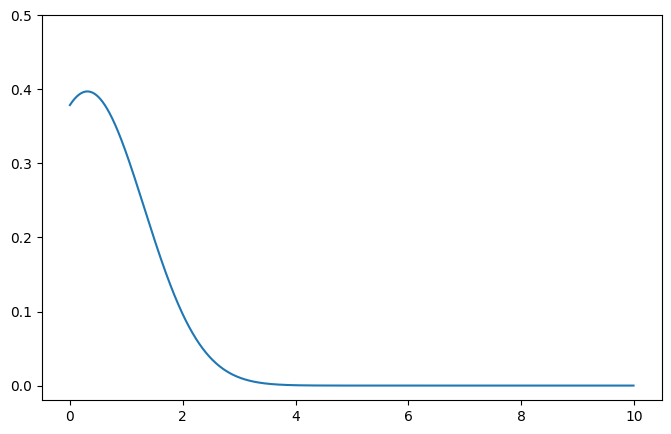

In [122]:
def plot_gauss(fun, fun_range):
    fig = plt.figure(figsize = (8,5))
    plt.plot(fun_range, fun)
    plt.yticks(np.arange(0,0.55,0.1))
    plt.show()

x = np.arange(0, 10., step=0.01)

plot_gauss(test_sample[2], x)

In [82]:
def calculate_h_for_features(samples, m):
    x = np.arange(0, m)
    new_hs = []
    for sample in samples:
        new_h = calculate_h(sample, m)
        sample = gauss_calc(x, sample, m, h=new_h)

        new_hs.append(new_h)
    
    return samples, new_hs
    
test_sample, hs = calculate_h_for_features(test_sample, 1000)

print(test_sample)

[array([3.43517769e-01, 3.45058297e-01, 3.46573701e-01, 3.48063591e-01,
       3.49527584e-01, 3.50965299e-01, 3.52376363e-01, 3.53760410e-01,
       3.55117078e-01, 3.56446012e-01, 3.57746863e-01, 3.59019289e-01,
       3.60262953e-01, 3.61477528e-01, 3.62662692e-01, 3.63818128e-01,
       3.64943531e-01, 3.66038599e-01, 3.67103041e-01, 3.68136570e-01,
       3.69138909e-01, 3.70109789e-01, 3.71048949e-01, 3.71956134e-01,
       3.72831100e-01, 3.73673609e-01, 3.74483434e-01, 3.75260354e-01,
       3.76004158e-01, 3.76714644e-01, 3.77391618e-01, 3.78034894e-01,
       3.78644298e-01, 3.79219663e-01, 3.79760830e-01, 3.80267652e-01,
       3.80739990e-01, 3.81177714e-01, 3.81580703e-01, 3.81948847e-01,
       3.82282044e-01, 3.82580203e-01, 3.82843242e-01, 3.83071089e-01,
       3.83263679e-01, 3.83420961e-01, 3.83542891e-01, 3.83629436e-01,
       3.83680571e-01, 3.83696283e-01, 3.83676567e-01, 3.83621429e-01,
       3.83530884e-01, 3.83404957e-01, 3.83243683e-01, 3.83047108e-01,
     

In [83]:
print(test_sample[2])

[3.20482014e-01 3.22459801e-01 3.24418697e-01 3.26358210e-01
 3.28277848e-01 3.30177121e-01 3.32055545e-01 3.33912637e-01
 3.35747917e-01 3.37560912e-01 3.39351148e-01 3.41118158e-01
 3.42861479e-01 3.44580652e-01 3.46275223e-01 3.47944741e-01
 3.49588762e-01 3.51206847e-01 3.52798562e-01 3.54363477e-01
 3.55901171e-01 3.57411227e-01 3.58893235e-01 3.60346789e-01
 3.61771492e-01 3.63166954e-01 3.64532790e-01 3.65868624e-01
 3.67174084e-01 3.68448810e-01 3.69692445e-01 3.70904644e-01
 3.72085066e-01 3.73233381e-01 3.74349265e-01 3.75432404e-01
 3.76482493e-01 3.77499232e-01 3.78482334e-01 3.79431519e-01
 3.80346516e-01 3.81227064e-01 3.82072911e-01 3.82883813e-01
 3.83659538e-01 3.84399862e-01 3.85104571e-01 3.85773461e-01
 3.86406339e-01 3.87003020e-01 3.87563331e-01 3.88087109e-01
 3.88574199e-01 3.89024459e-01 3.89437758e-01 3.89813972e-01
 3.90152992e-01 3.90454715e-01 3.90719053e-01 3.90945926e-01
 3.91135266e-01 3.91287015e-01 3.91401127e-01 3.91477565e-01
 3.91516304e-01 3.915173

In [84]:
def determine_if_typical(r, m, vals, h):
  # gauss_y = gauss_calc(x, random_nums, m, K = k, h=1.0)
  gauss_y = []
  for i in range(m):
    # for j in range(m):
    temp = np.delete(vals, i, axis=0)
    gauss_y.append(gauss_calc(vals[i], temp, m - 1, K = k, h=h))

  typical_arr = {}
  gauss_y = dict(enumerate(gauss_y, 0))

  # q = estimate_q(gauss_y, r, m)
  gauss_y = sorted(gauss_y.items(), key=lambda x:x[1])
  gauss_y = dict(gauss_y)
  gauss_items = list(gauss_y.values())
  q = gauss_items[0 if  m*r < 0.5 else int(m*r + 0.5)]
  for idx, val in gauss_y.items():
    if idx < 1000:
      if val <= q:
        typical_arr[vals[idx]] = 1
      else:
        typical_arr[vals[idx]] = 0
  return typical_arr

In [85]:
def determine_if_typical_for_features(samples, r, m, hs):
    typical_arrs = []
    
    for sample, h in zip(samples, hs):
        typical_arr = determine_if_typical(r, m, sample, h)
        typical_arrs.append(typical_arr)

    return typical_arrs

typical_arrs = determine_if_typical_for_features(test_sample, 0.05, 1000, hs)

In [86]:
len(typical_arrs)

3

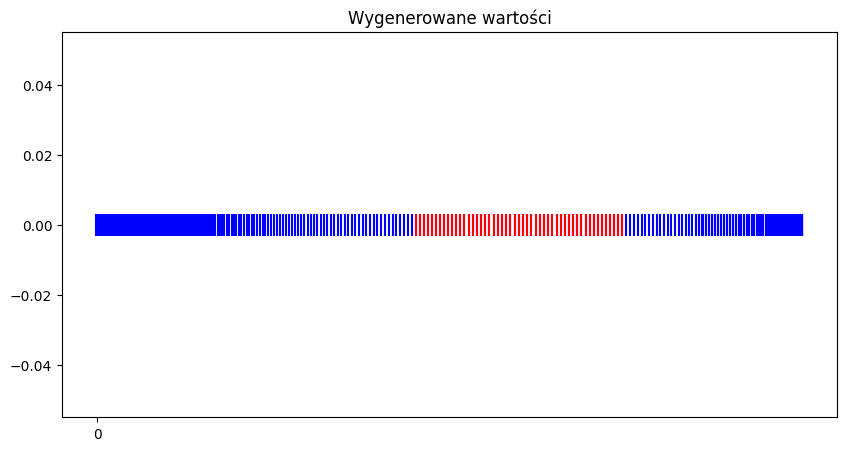

In [88]:
def plot_colored_nums(data, num_of_points, typical):
  fig, ax = plt.subplots(figsize=(10, 5))
  # ax.set_xlim(0, 10)
  # ax.set_ylim(0, 0.5)
  ax.xaxis.set_major_locator(MultipleLocator(1))
  ax.set_title(f'Wygenerowane wartości')

  atypical_nums = sum(typical.values())

  plt.scatter(data, np.full(num_of_points, 0), marker='|', c='blue', s=250)
  for rand in data:
    if typical[rand] == 1:
      plt.scatter(rand, 0, marker='|', c='red', s=250)
  plt.show()

plot_colored_nums(test_sample[1], 1000, typical_arrs[1])